## SKU TO VEC

# I. Problem: <br />
You have a website and there are many interactions between objects on the website likes user-item (e-commercial web), user-user (social web). You want to create a recommendation system or build a network that show the relationship of these objects. One of solutions is convert objects into vectors in which computer can calculate the similarity between of them in easy ways: put 2 vecotor into quick function for example similar(A,B) = A x B, or any more complexed functions like deep models. In this documment I will show you step by step to build a ranking system that can convert objects to vectors and calculate the simmilarity of them base on similar(A,B) = A x B.

Solution: I will using deep learning as a tool to convert users and items to vector base on users' actions.

### Reference
https://arxiv.org/pdf/1103.0398.pdf

http://sebastianruder.com/word-embeddings-1/index.html#continuousbagofwordscbow

# II. Introduction to Word embedding models

Naturally, every feed-forward neural network that takes words from a vocabulary as input and embeds them as vectors into a lower dimensional space, which it then fine-tunes through back-propagation, necessarily yields word embeddings as the weights of the first layer, which is usually referred to as Embedding Layer.

The main difference between such a network that produces word embeddings as a by-product and a method such as word2vec whose explicit goal is the generation of word embeddings is its computational complexity. Generating word embeddings with a very deep architecture is simply too computationally expensive for a large vocabulary. This is the main reason why it took until 2013 for word embeddings to explode onto the NLP stage; computational complexity is a key trade-off for word embedding models

#### 1 Embedding Layer: 
A layer that generates word embeddings by multiplying an index vector with a word embedding matrix;
#### 2 Intermediate Layer(s):
One or more layers that produce an intermediate representation of the input, e.g. a fully-connected layer that applies a non-linearity to the concatenation of word embeddings of nn previous words;
#### 3 Cost Layer:
The final layer that produces a probability distribution over words in VV.

### a. Example model: CBOW model

<img src="img/cbow.png">

### The pairwise ranking criterion, which looks like this:

   <img src="img/margin_1_loss.png">
    

# III. Implement Bayesian Personalize Ranking

### Import library <br />
    - pandas to read and preprocess data.
    - numpy to calculate output number.
    - Tensorflow to build model <br />

In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import collections
import random
import math

### Imports, config variables, and data generators

In [25]:
# Global config variables
batch_size = 12 # 128
num_classes = 10 # number of skus and zuids ~700.000 
# The sample is small, we only have 4 users and 6 items. So we only need a vector lenght 4 to represent 
# the users and items
state_size = 4 # 8, 16, 32, 64, 128
learning_rate = 0.001 

### Inputs:
Input is a file that contains action logs of users. 
    - First line is name of column: zuid, action_type, sku. zuid is user id. Action_type: 6 is buy, 2 is view. Sku is item id. Seprated by a tab.
    - From second line to end of file each line is a action of a user on a item. 
    
Example:
    - "Victor	6	Convert" means: user Victor buy item Convert.
    - "Niko	2 	Adidas" means: user Niko view item Adidas. 

In [3]:
class generator():
    def __init__(self, file_name):
        self.read_data_from_file(file_name)
        self.create_map()
        self.create_action_dict()
        
    def maybe_download_file(self, date):
        pass
    
    def read_data_from_file(self, file_name = 'data/sample_input.csv'):
        # maybe_download_file
        self.df = pd.read_csv(filepath_or_buffer = file_name, header=0, sep='\t')
        
    def _create_map(self, set_items):
        n_items = len(set_items)
        index_2_item_map = dict(zip(range(n_items), set_items))
        item_2_index_map = dict(zip(set_items, range(n_items)))
        return index_2_item_map, item_2_index_map

    def create_map(self):
        self.n_zuids = len(set(self.df['zuid']))
        self.n_skus = len(set(self.df['sku']))
        self.skus = set(self.df['sku'])
        self.index_2_zuid_map, self.zuid_2_index_map = self._create_map(set(self.df['zuid']))
        self.index_2_sku_map, self.sku_2_index_map = self._create_map(set(self.df['sku']))

    def create_action_dict(self):
        self.d = collections.defaultdict(set)
        for (_, row) in self.df.iterrows():
            self.d[row['zuid']].add(row['sku'])
            self.d[(row['zuid'], row['action_type'])].add(row['sku'])
        for zuid in self.df['zuid']:
            self.d[(zuid, 2)] = self.d[zuid] - self.d[(zuid, 6)]

    def get_random_row(self):
        x = list(range(len(self.df)))
        random.shuffle(x)
        for i in x:
            yield self.df.loc[i]
            
    def _gen_sample(self):
        for row in self.get_random_row():
            zuid = row['zuid']
            item_i = row['sku']
            if (row['action_type'] == 6) and (len(self.d[(zuid, 2)]) > 0):
                item_j = random.sample(self.d[(zuid, 2)], 1)[0]
                yield(self.zuid_2_index_map[zuid],\
                     self.sku_2_index_map[item_i],\
                     self.sku_2_index_map[item_j])
                
            item_j = random.sample(self.skus,1)[0]
            while (item_j in self.d[(zuid, 6)]):
                item_j = random.sample(self.skus,1)[0]
            yield(self.zuid_2_index_map[zuid],\
                     self.sku_2_index_map[item_i],\
                     self.sku_2_index_map[item_j])
        
    def gen_sample(self):
        iterator = self._gen_sample()
        gotone = False
        try:
            lookback = next(iterator)
            gotone = True
            while True:
                cur = next(iterator)
                yield False, lookback
                lookback = cur
        except StopIteration:
            if gotone:
                yield True, lookback
            raise StopIteration()
            
    def gen_batch(self, batch_size):
        iterator = self._gen_sample()
        gotone = False
        try:
            while True:
                zuids, skus_i, skus_j = [], [], []
                for i in range(batch_size):
                    zuid, sku_i, sku_j = next(iterator)
                    zuids.append([zuid])
                    skus_i.append([sku_i])
                    skus_j.append([sku_j])
                yield False, (zuids, skus_i, skus_j)
        except StopIteration:
            yield True, ([], [], [])
            
    def sanity_check_create_map(set_items = ''):
        if set_items == '':
            set_items = set(['a', 'b', 'c', 'd'])
        index_2_item_map, item_2_index_map = create_map(set_items)
        try:
            for i in set_items:
                assert(index_2_item_map[item_2_index_map[i]] == i)
        except Exception as e:
            print(e)
            print('Sanity check: False')
        print('Sanity check: Pass')
    
    def sanity_check_generate_sample(df, d):
        for (zuid, sku_i, sku_j) in get_sample(df):
            # check zuid have interaction with sku_i
            assert((sku_i in d[zuid]))
            if sku_j in d[(zuid, 2)]:
                assert((sku_i in d[(zuid,6)]))
        print("Sanity check: Pass") 

    def gen_epochs(n, num_steps):
        for i in range(n):
            yield gen_batch(gen_data(), batch_size, num_steps)
            
# t = generator('data/sample_input.csv')
# x = t.gen_batch(batch_size)
# print(next(x))

### Model

If we treat a continuous sequence of actions of a user in a transaction as a sentences, the sku will play a role as a word.
<img src="img/model_v1.png">

### Helper-functions for creating new variables

In [4]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Bayersian Personalize Ranking (BPR)

Loss function:
<img src="img/objective_function.png">

with: 

<img src="img/BPR_loss.png">

and,

<img src="img/BPR_loss_2.png">


In [5]:
# Placeholders
u_index = tf.placeholder(tf.int32, [batch_size,1], name = 'zuid')
x_i_index = tf.placeholder(tf.int32, [batch_size,1], name = 'xi')
x_j_index = tf.placeholder(tf.int32, [batch_size,1], name = 'xj')

In [6]:
# Variables

#lookup table 
embedding_skus = new_weights([num_classes, state_size])
embedding_zuids = new_weights([num_classes, state_size])
# input vectors
u = tf.nn.embedding_lookup(embedding_zuids, u_index)
x_i = tf.nn.embedding_lookup(embedding_skus, x_i_index)
x_j = tf.nn.embedding_lookup(embedding_skus, x_j_index)

## Model 

<img src="img/BPR_loss_2.png">

In [7]:
x_ui = tf.matmul(u, x_i, transpose_a=False, transpose_b=True)
x_ui = tf.squeeze(x_ui)
x_uj = tf.matmul(u, x_j, transpose_a=False, transpose_b=True)
x_uj = tf.squeeze(x_uj)

<img src="img/BPR_loss.png">

In [8]:
g_zuid = tf.reduce_mean(tf.multiply(embedding_zuids,embedding_zuids)[0:4,:][:])
g_sku = tf.reduce_mean(tf.multiply(embedding_skus,embedding_skus)[0:6,:][:])
x_uij = tf.log(tf.nn.sigmoid(x_ui - x_uj))
x_uij_mean = tf.reduce_mean(tf.log(tf.nn.sigmoid(x_ui - x_uj)))

## Cost-function to be optimized

In [9]:
loss = 0.001 * (g_zuid + g_sku) - x_uij_mean

## Optimization Method

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

## Support function AUC estimator

<img src="img/AUC.png">

In [11]:
ranking_matrix = tf.matmul(embedding_zuids,embedding_skus, transpose_b=True) 

## TensorFlow Training model

In [12]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [13]:
t = generator('data/sample_input.csv')

In [14]:
losses = list()
aucs = list()

In [15]:
def train(n_iter = 100):
    for i in range(n_iter):
        batchs = t.gen_batch(batch_size)
        (is_end, (zuids, items_i, items_j)) = next(batchs)
        while is_end == False:
            feed_dict_train = {u_index : zuids,\
                                x_i_index : items_i,\
                                x_j_index : items_j}
            _, batch_loss, auc = session.run([optimizer, loss, x_uij], feed_dict=feed_dict_train)
            losses.append(batch_loss)
            aucs.append(sum(auc > math.log(0.5)) / len(auc))
            (is_end, (zuids, items_i, items_j)) = next(batchs)

### Train and plot lost and auc accuracy for the first 100 iterations:

In [16]:
train(n_iter = 100)

Loss while training phase.


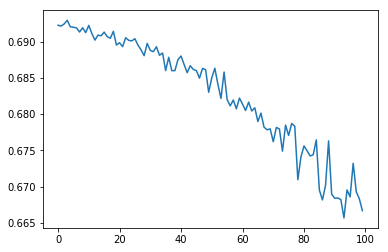

In [17]:
plt.plot(list(range(len(losses))), losses)
print("Loss while training phase.")
plt.show()

AUC while training. As the graph below show that AUC on test is going around 80%.


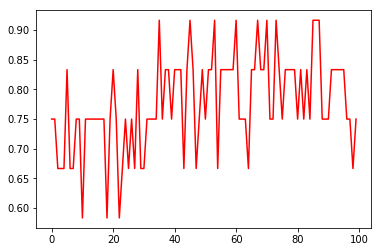

In [18]:
plt.plot(list(range(len(aucs))), aucs, 'r')
print("AUC while training. As the graph below show that AUC on test is going around 80%.")
plt.show()

### Train and plot lost and auc accuracy for the next 900 iterations:

In [19]:
train(n_iter = 900)

Loss while training phase.


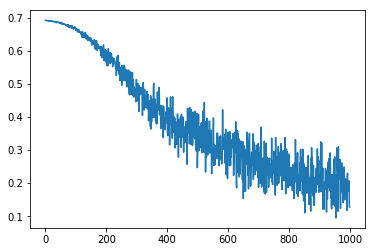

In [20]:
plt.plot(list(range(len(losses))), losses)
print("Loss while training phase.")
plt.show()

AUC while training. As the graph below show that AUC on test is going more than 90%.


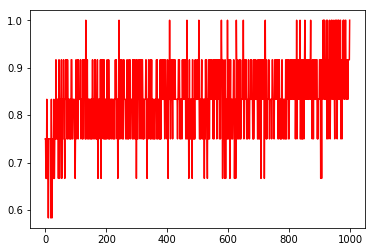

In [21]:
plt.plot(list(range(len(aucs))), aucs, 'r')
print("AUC while training. As the graph below show that AUC on test is going more than 90%.")
plt.show()

### Write result to test the toy example:

The output vector of zuids and skus will be extract to skus_vec and zuids_vec. We can reuse the result base on these vectors. For example:

In [22]:
# embedding_skus
# embedding_zuid
skus_vec = session.run(embedding_skus)
zuids_vec = session.run(embedding_zuids)
ranking= session.run(ranking_matrix)
g_zuid_num = session.run(g_zuid)
g_sku_num = session.run(g_sku)

In [23]:
for zuid in range(t.n_zuids):
    print(t.index_2_zuid_map[zuid])
    favorite_list = np.argsort(-ranking[zuid,:])
    for sku in favorite_list:
        try:
            print(t.index_2_sku_map[sku])
        except:
            pass

d
i2
i3
i4
i6
i1
i5
a
i1
i5
i3
i2
i4
i6
c
i6
i4
i5
i3
i2
i1
b
i1
i5
i3
i2
i4
i6
